In [18]:
IRdisplay::display_html(file='code_hiding.html')

The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click 
 here .

In [1]:
library(data.table) # see https://cran.r-project.org/web/packages/data.table/vignettes/datatable-intro.html for reference
library(ggplot2)
dataTag <- "pilot3_FIRA"
datafile <- paste("~/programing/data/psychophys/",dataTag,".csv",sep='')
data <- fread(file=datafile, header=TRUE, sep=",")
str(data)

Classes ‘data.table’ and 'data.frame':	18 obs. of  24 variables:
 $ taskID         : int  2 2 2 2 2 2 2 2 2 2 ...
 $ trialIndex     : int  18 6 5 11 8 10 15 17 13 7 ...
 $ trialStart     : num  56156 56161 56165 56169 56173 ...
 $ trialEnd       : num  56161 56165 56169 56173 56178 ...
 $ RT             : num  0.809 0.818 0.623 0.705 0.376 ...
 $ choice         : int  0 0 1 0 1 1 0 1 0 0 ...
 $ correct        : int  0 0 1 0 1 1 1 0 1 1 ...
 $ initDirection  : int  0 0 0 0 0 0 0 180 180 180 ...
 $ endDirection   : int  0 0 0 0 0 0 180 180 180 180 ...
 $ presenceCP     : int  0 0 0 0 0 0 1 0 0 0 ...
 $ coherence      : num  25.6 25.6 25.6 25.6 6.4 12.8 12.8 25.6 6.4 6.4 ...
 $ viewingDuration: num  0.3 0.1 0.1 0.2 0.2 0.2 0.3 0.3 0.3 0.2 ...
 $ probCP         : num  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...
 $ timeCP         : num  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 ...
 $ randSeedBase   : int  894 6608 4314 1796 3488 9122 1953 1412 1065 7461 ...
 $ fixationOn     : num  0.344 0.2

## Basic questions that we may ask
### How long did the session last?

In [2]:
cat( round(data[,sum(trialEnd - trialStart)] / 60, digits = 2), "min" )

1.35 min

### How many trials were produced?

In [3]:
numTrials <- length(unique(data$trialIndex))
# display warning if somehow a trial or more are duplicated
duplicates <- numTrials != nrow(data)
if (duplicates) {
  print("some trials are duplicated -- remainder of notebook should NOT be executed")
} else {
  cat(numTrials, "trials")
}

18 trials

### How many trials were produced per combination of factors?

In [4]:
source("R_functions.r")
indepVarNames <- c("initDirection","presenceCP","coherence","viewingDuration","probCP","timeCP")
combFactors <- getFreq(data, indepVarNames)
combFactors

initDirection,presenceCP,coherence,viewingDuration,probCP,timeCP,freq.
0,0,25.6,0.3,0.5,0.2,1
0,0,25.6,0.1,0.5,0.2,2
0,0,25.6,0.2,0.5,0.2,1
0,0,6.4,0.2,0.5,0.2,1
0,0,12.8,0.2,0.5,0.2,1
0,1,12.8,0.3,0.5,0.2,1
180,0,25.6,0.3,0.5,0.2,1
180,0,6.4,0.3,0.5,0.2,2
180,0,6.4,0.2,0.5,0.2,1
180,0,6.4,0.1,0.5,0.2,2


### What were the marginal frequencies?

In [5]:
for (i in 1:length(indepVarNames)) {
  print(getFreq(data, indepVarNames[i]))
}

   initDirection freq.
1:             0     7
2:           180    11
   presenceCP freq.
1:          0    17
2:          1     1
   coherence freq.
1:      25.6     6
2:       6.4     6
3:      12.8     6
   viewingDuration freq.
1:             0.3     6
2:             0.1     6
3:             0.2     6
   probCP freq.
1:    0.5    18
   timeCP freq.
1:    0.2    18


### What is the accuracy on the task?

In [6]:
accuracy <- sum(data[,correct])/numTrials
cat(accuracy * 100,"%", sep = '')

44.44444%

#### Accuracy on CP vs. non-CP trials

In [7]:
# count CP and Non-CP trials
cpGrouping <- getFreq(data, "presenceCP")
numCPtrials <- cpGrouping[presenceCP == 1, freq.]
numNonCPtrials <- cpGrouping[presenceCP == 0, freq.]

# compute accuracies in each group of trials
accuracy_CP <- sum(data[presenceCP == 1, correct])/numCPtrials * 100
accuracy_nonCP <- sum(data[presenceCP == 0, correct])/numNonCPtrials * 100
# round to 2 decimals
accuracy_CP <- round(accuracy_CP, digits = 2)
accuracy_nonCP <- round(accuracy_nonCP, digits = 2)

# display summarizing table
toDisplay <- cpGrouping[, ("accuracy") := data.frame("accuracy"=c(accuracy_nonCP, accuracy_CP))]
print(toDisplay)
toDisplay # print a second time because of a bug that I don't fully understand (see https://github.com/IRkernel/IRkernel/issues/127 and https://github.com/rstudio/rmarkdown/issues/1002)

   presenceCP freq. accuracy
1:          0    17    41.18
2:          1     1   100.00


presenceCP,freq.,accuracy
0,17,41.18
1,1,100.00


#### Accuracy as a function of viewing duration

In [8]:
# first get marginal frequencies
toDisplay <- data[order(viewingDuration),.(freq = .N, correct = sum(correct)), by=viewingDuration]

# then add the accuracy column
toDisplay <- toDisplay[,.(viewingDuration, freq, correct, accuracy = round(correct/freq*100,digits=2))]
toDisplay

viewingDuration,freq,correct,accuracy
0.1,6,3,50.00
0.2,6,3,50.00
0.3,6,2,33.33


#### Accuracy as a function of coherence level

In [9]:
# first get marginal frequencies
toDisplay <- data[order(coherence),.(freq = .N, correct = sum(correct)), by=coherence]

# then add the accuracy column
toDisplay <- toDisplay[,.(coherence, freq, correct, accuracy = round(correct/freq*100,digits=2))]
toDisplay

coherence,freq,correct,accuracy
6.4,6,4,66.67
12.8,6,3,50.00
25.6,6,1,16.67


#### Group by change point presence after CP time

In [10]:
# first get marginal frequencies
toDisplay <- data[viewingDuration > .2,
                  .(freq = .N, correct = sum(correct)), 
                  by=.(viewingDuration, presenceCP)]
# then add the accuracy column
toDisplay <- toDisplay[,.(viewingDuration, freq, correct, presenceCP,  accuracy = round(correct/freq*100,digits=2))]
toDisplay

viewingDuration,freq,correct,presenceCP,accuracy
0.3,5,1,0,20
0.3,1,1,1,100


### How precise were the dots timings?
We plot `(dotsOff - dotsOn) - viewingDuration`, across all trials, and overlay average durations of 1 and 2 frames (dashed lines).

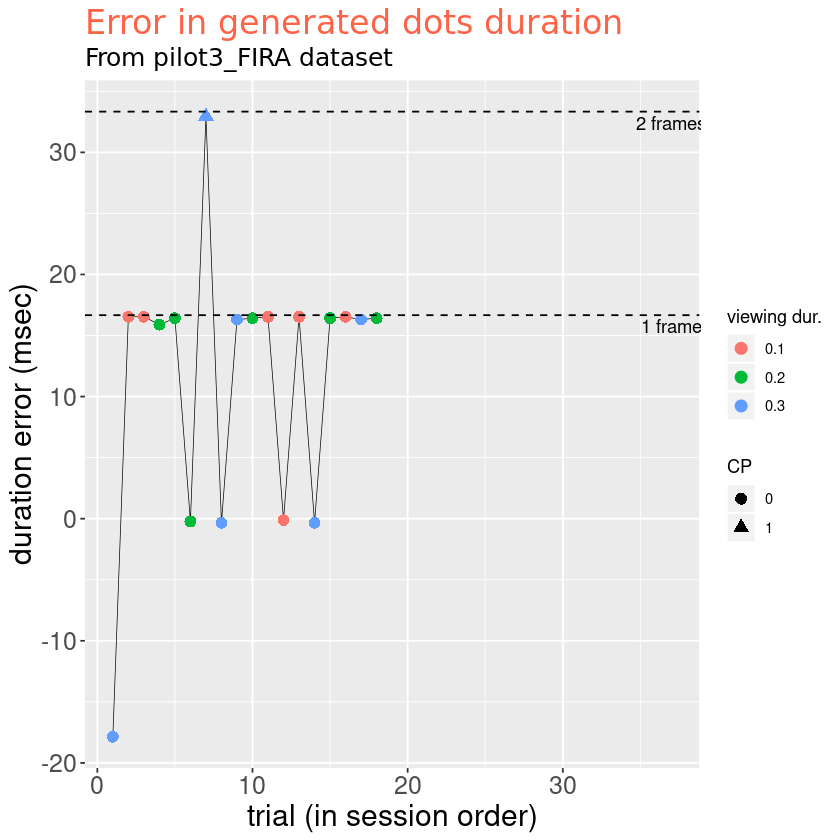

In [11]:
axes_labels_font <- 18
axes_font <- 15
frameRate <- 60 # rounded estimate obtained from dotsTheScreen.windowFrameRate
frameDuration <- (1 / frameRate) * 1000 # in msec
frameDurations <- c(frameDuration, 2*frameDuration)

durTable <- data[,.(dotsDurationError = (dotsOff - dotsOn - viewingDuration) * 1000, presenceCP, viewingDuration)]

# call to ggplot()
g <- ggplot(durTable, aes(x=1:nrow(durTable), y=dotsDurationError)) + 
  geom_line(size=.2) +  
  geom_point(aes(shape=factor(presenceCP), col=factor(viewingDuration)),size=3) +
  geom_hline(yintercept = frameDurations, linetype="dashed") +
  annotate("text", x=37, y=frameDurations, vjust = 1.3, label = c("1 frame","2 frames"))
# Add Title and Labels
g + labs(title="Error in generated dots duration", 
         subtitle=paste("From",dataTag,"dataset",sep=" "), 
         y="duration error (msec)", 
         x="trial (in session order)",
         color="viewing dur.", shape="CP") + theme(plot.title=element_text(size=20, 
                                    family="American Typewriter",
                                    color="tomato",
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, 
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=axes_labels_font),  # X axis title
            axis.title.y=element_text(size=axes_labels_font),  # Y axis title
            axis.text.x=element_text(size=axes_font),  # X axis text
            axis.text.y=element_text(size=axes_font))  # Y axis text

Note how the largest errors (roughly 40msec) occur on longest viewing duration trials which contain a change point (blue triangles).

Also, there seems to be 3 main error magnitudes as points cluster around integer multiples of the average frame duration. In the `meanDurationError` column below, we compute the average error duration for each cluster. With an approximate frame rate of 60, we present in `num_frames` the approximate number of frames for these three durations.

In [12]:
# note, it might be ideal to leverage the following package
# library("pomp2")
# see documentation for pomp2 package
# pdf: file:///home/adrian/Downloads/v69i12.pdf
# website: https://kingaa.github.io/pomp/vignettes/upgrade_guide.html

# for now, very simple algo.
# bin duration errors into 3 bins
intervals <- bin(durTable[,.(dotsDurationError)], nbins = 3, method = "cluster")
names(intervals) <- "interval"

# add the bins as a factor to the data.table
durTable[, ("interval") := intervals]

# compute mean durations
unordered <- durTable[, .(num_trials=.N, meanDurationError = mean(dotsDurationError)), by = intervals]

# display results, with num_frame column
unordered[order(meanDurationError),.(num_trials, meanDurationError, num_frames = (meanDurationError * frameRate / 1000))]

ERROR: Error in bin(durTable[, .(dotsDurationError)], nbins = 3, method = "cluster"): could not find function "bin"


Finally, the error increases by a few milliseconds with each 100 msec of viewing duration. That is, in a given cluster, colors are roughly vertically ordered.

### Explore random seed

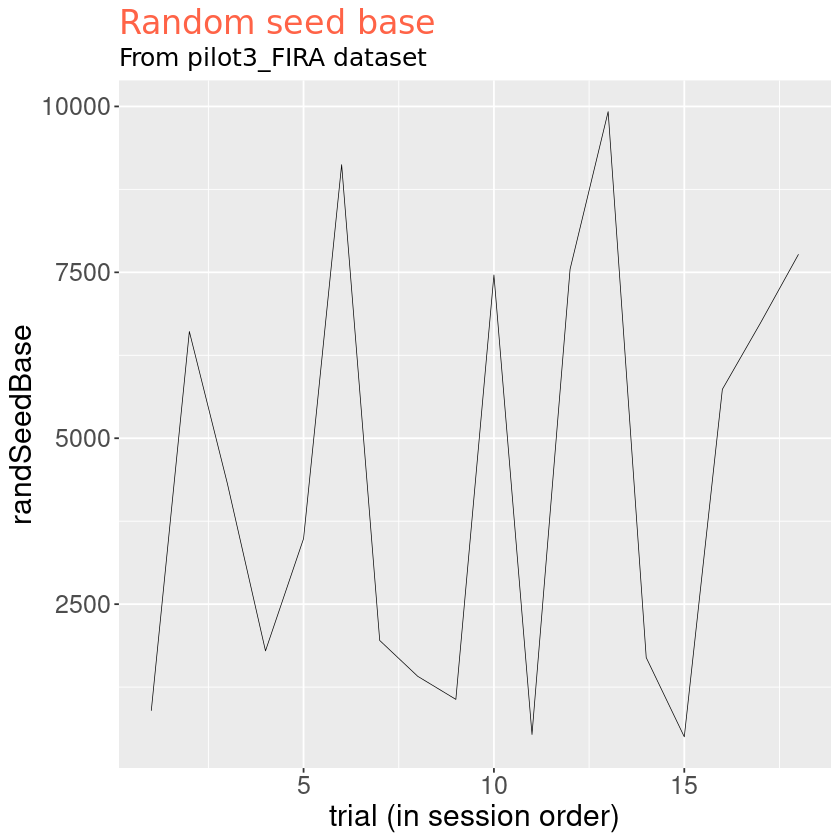

In [13]:
axes_labels_font <- 18
axes_font <- 15
seedTable <- data[,.(randSeedBase,trialIndex)]
g <- ggplot(seedTable, aes(x=1:nrow(seedTable), y=randSeedBase)) + 
  geom_line(size=.2) #+  geom_point(aes(shape=factor(presenceCP), col=factor(viewingDuration)),size=3) 

# Add Title and Labels
g + labs(title="Random seed base", 
         subtitle=paste("From",dataTag,"dataset",sep=" "), 
         y="randSeedBase", 
         x="trial (in session order)") + theme(plot.title=element_text(size=20, 
                                    family="American Typewriter",
                                    color="tomato",
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, 
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=axes_labels_font),  # X axis title
            axis.title.y=element_text(size=axes_labels_font),  # Y axis title
            axis.text.x=element_text(size=axes_font),  # X axis text
            axis.text.y=element_text(size=axes_font))  # Y axis text